In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [21]:
def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [97]:
# Read in the model performances
rel_file = "../REL_output/all_metrics.tsv"
ner_file = "../NER_output/aggregated_eval.tsv"
rel_df = pd.read_csv(rel_file, delimiter="\t", index_col=0)
ner_df = pd.read_csv(ner_file, delimiter="\t", index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: '../REL_output/all_metrics.tsv'

### NER

In [98]:
labels_flat = ner_df.columns.tolist()

In [52]:
m = ner_df.transpose().reset_index()
m = m.rename(columns={"index": "metric"})
columns = ["eval_f1", "eval_precision", "eval_recall", "eval_loss", "test_f1", 
           "test_precision", "test_recall","test_loss"]
mf = m[m["metric"].isin(columns)]
mf["group"] = mf["metric"].str.split("_").str[0]
mf["metric"] = mf["metric"].str.replace("eval_", "", regex=True).str.replace(
    "test_", "", regex=True).str.replace("train_", "", regex=True)
matrices = []
for group in mf.group.unique():
    matrix = mf[mf["group"] == group].loc[:, labels_flat].values.tolist()
    matrices.append((group, matrix))
data_mine = [labels_flat, matrices[0], matrices[1]]
N = len(labels_flat)
theta = radar_factory(N, frame='polygon')
data = data_mine
spoke_labels = data.pop(0)

/tmp/ipykernel_59862/1171194581.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mf["group"] = mf["metric"].str.split("_").str[0]
/tmp/ipykernel_59862/1171194581.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mf["metric"] = mf["metric"].str.replace("eval_", "", regex=True).str.replace(


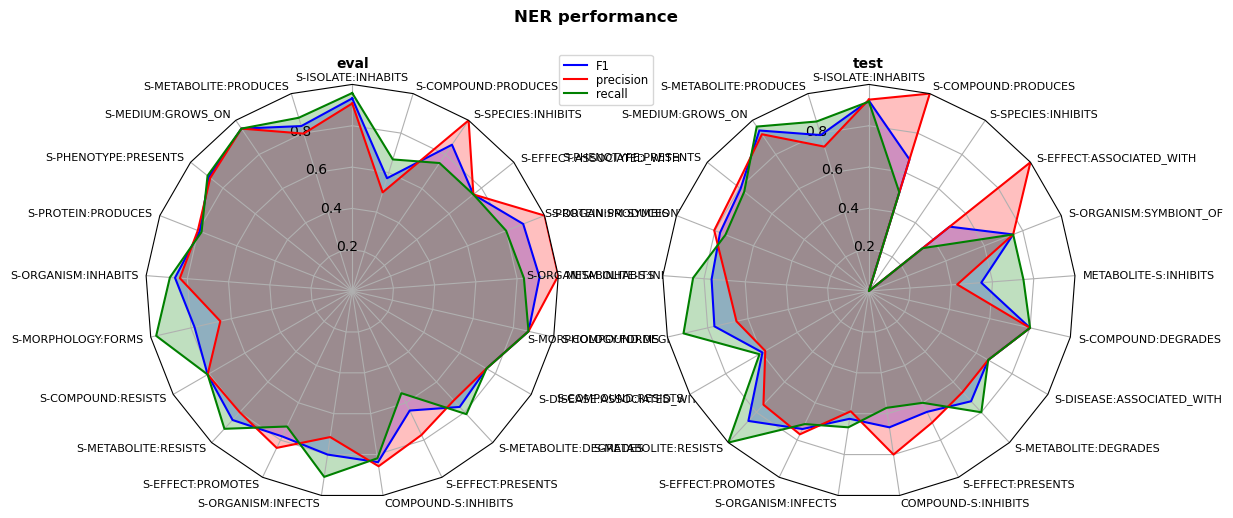

In [96]:
fig, axs = plt.subplots(figsize=(12, 6), ncols=2,
						subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

legend_labels = []

for ax, (title, case_data) in zip(axs.flat, data):
	ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
	ax.set_ylim(0, 1)
	ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
				 horizontalalignment='center', verticalalignment='center')
	
	colors = ['b', 'r', 'g', 'm']  # Move colors inside the loop
	
	for d, color in zip(case_data, colors):
		ax.plot(theta, d, color=color)
		ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
	ax.set_varlabels(spoke_labels)
	legend_labels.extend(case_data)
	
	# Rotate the axis labels
	ax.set_thetagrids(np.degrees(theta), spoke_labels, fontsize=8)
	ax.tick_params(axis='x', pad=-5)  # Remove padding of x-tick labels
	for label, angle in zip(ax.get_xticklabels(), np.degrees(theta)):
		if angle in (0, 180):
			label.set_horizontalalignment('center')
		elif 0 < angle < 180:
			label.set_horizontalalignment('right')
		else:
			label.set_horizontalalignment('left')

# add legend relative to top-left plot
labs = tuple(mf.metric.drop_duplicates().to_list())
legend = axs[0].legend(labs, loc=(1, .95),
					   labelspacing=0.1, fontsize='small')

fig.text(0.5, 0.9, 'NER performance',
		 horizontalalignment='center', color='black', weight='bold',
		 size='large')

plt.savefig("figures/performance/ner.pdf", bbox_inches='tight')


#### REL

In [66]:
labels_flat = rel_df.index.tolist()

In [70]:
m = rel_df.transpose().reset_index()
m = m.rename(columns={"index": "metric"})

In [71]:
columns = ["eval_f1", "eval_precision", "eval_recall", "test_f1", 
           "test_precision", "test_recall"]

,metric,STRAIN-ISOLATE:INHABITS,STRAIN-METABOLITE:PRODUCES,STRAIN-MEDIUM:GROWS_ON,STRAIN-PHENOTYPE:PRESENTS,STRAIN-PROTEIN:PRODUCES,STRAIN-ORGANISM:INHABITS,STRAIN-MORPHOLOGY:FORMS,STRAIN-COMPOUND:RESISTS,STRAIN-METABOLITE:RESISTS,...,COMPOUND-STRAIN:INHIBITS,STRAIN-EFFECT:PRESENTS,STRAIN-METABOLITE:DEGRADES,STRAIN-DISEASE:ASSOCIATED_WITH,STRAIN-COMPOUND:DEGRADES,METABOLITE-STRAIN:INHIBITS,STRAIN-ORGANISM:SYMBIONT_OF,STRAIN-EFFECT:ASSOCIATED_WITH,STRAIN-SPECIES:INHIBITS,STRAIN-COMPOUND:PRODUCES
0,epoch,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,...,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
1,eval_F1,0.932432,0.835616,0.951613,0.886792,0.792683,0.859813,0.782609,0.807692,0.851064,...,0.837209,0.641509,0.764706,0.750000,0.875000,0.909091,0.888889,0.750000,0.857143,0.571429
2,eval_precision,0.907895,0.797386,0.951613,0.878505,0.802469,0.836364,0.654545,0.807692,0.800000,...,0.857143,0.772727,0.722222,0.750000,0.875000,1.000000,1.000000,0.750000,1.000000,0.500000
3,eval_recall,0.958333,0.877698,0.951613,0.895238,0.783133,0.884615,0.972973,0.807692,0.909091,...,0.818182,0.548387,0.812500,0.750000,0.875000,0.833333,0.800000,0.750000,0.750000,0.666667
4,eval_samples,223.000000,399.000000,139.000000,155.000000,218.000000,232.000000,59.000000,177.000000,399.000000,...,177.000000,150.000000,399.000000,54.000000,177.000000,399.000000,232.000000,150.000000,331.000000,177.000000
5,test_F1,0.921466,0.790000,0.940476,0.794118,0.773585,0.763158,0.766667,0.594595,0.857143,...,0.666667,0.648649,0.727273,0.666667,0.800000,0.545455,0.750000,0.500000,0.000000,0.666667
6,test_precision,0.926316,0.731481,0.918605,0.818182,0.803922,0.690476,0.657143,0.578947,0.750000,...,0.800000,0.705882,0.666667,0.666667,0.800000,0.428571,0.750000,1.000000,0.000000,1.000000
7,test_recall,0.916667,0.858696,0.963415,0.771429,0.745455,0.852941,0.920000,0.611111,1.000000,...,0.571429,0.600000,0.800000,0.666667,0.800000,0.750000,0.750000,0.333333,0.000000,0.500000
8,test_samples,148.000000,265.000000,92.000000,103.000000,144.000000,154.000000,39.000000,117.000000,265.000000,...,117.000000,100.000000,265.000000,35.000000,117.000000,265.000000,154.000000,100.000000,220.000000,117.000000
9,train_loss,0.238704,0.210813,0.202972,0.346678,0.306841,0.170442,0.444596,0.197463,0.059462,...,0.104930,0.254963,0.053135,0.156577,0.074598,0.019585,0.026374,0.061000,0.016595,0.047604


In [83]:
m = rel_df.transpose().reset_index()
m = m.rename(columns={"index": "metric"})
columns = ["eval_F1", "eval_precision", "eval_recall", "test_F1", 
           "test_precision", "test_recall"]
mf = m[m["metric"].isin(columns)]
mf["group"] = mf["metric"].str.split("_").str[0]
mf["metric"] = mf["metric"].str.replace("eval_", "", regex=True).str.replace(
    "test_", "", regex=True).str.replace("train_", "", regex=True)
matrices = []
for group in mf.group.unique():
    matrix = mf[mf["group"] == group].loc[:, labels_flat].values.tolist()
    matrices.append((group, matrix))
data_mine = [labels_flat, matrices[0], matrices[1]]
N = len(labels_flat)
theta = radar_factory(N, frame='polygon')

data = data_mine
spoke_labels = data.pop(0)
spoke_labels = [w.replace("STRAIN","S") for w in spoke_labels]



/tmp/ipykernel_59862/1603370077.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mf["group"] = mf["metric"].str.split("_").str[0]
/tmp/ipykernel_59862/1603370077.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mf["metric"] = mf["metric"].str.replace("eval_", "", regex=True).str.replace(


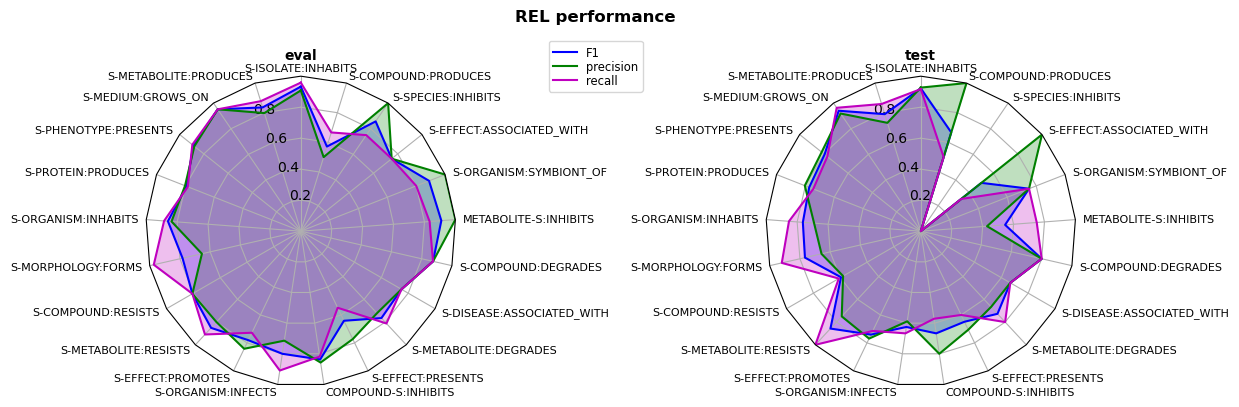

In [102]:
fig, axs = plt.subplots(figsize=(12, 6), ncols=2,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=1, hspace=0.20, top=0.85, bottom=0.05)

colors = ['b', 'g', 'm']
legend_labels = []

for ax, (title, case_data) in zip(axs.flat, data):
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_ylim(0, 1)
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
    ax.set_varlabels(spoke_labels)
    legend_labels.extend(case_data)
    
    # Rotate the axis labels
    ax.set_thetagrids(np.degrees(theta), spoke_labels, fontsize=8)
    ax.tick_params(axis='x', pad=-5)  # Remove padding of x-tick labels
    for label, angle in zip(ax.get_xticklabels(), np.degrees(theta)):
        if angle in (0, 180):
            label.set_horizontalalignment('center')
        elif 0 < angle < 180:
            label.set_horizontalalignment('right')
        else:
            label.set_horizontalalignment('left')


# add legend relative to top-left plot
labs = tuple(mf.metric.drop_duplicates().to_list())
legend = axs[0].legend(labs, loc=(1.3, .95),
                       labelspacing=0.1, fontsize='small')

fig.text(0.5, 0.8, 'REL performance',
         horizontalalignment='center', color='black', weight='bold',
         size='large')

plt.savefig("figures/performance/rel.pdf", bbox_inches='tight')